3. add headers to each new chapter and list of contents in the beginning
4. add up plugins from world itself and from models that are in it

note: to count joints only makes sense if we add plugins from models as well, the same goes for sensors (and plugins)



# Gazebo Worlds Complexity Analysis

In [356]:
import os, statistics, itertools, json
import xml.etree.ElementTree as ET
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path
from utilities import remove_duplicates, get_all_elements

In [357]:
# inside there are files
with open('worlds_locations.json') as f:
    project_relative_locations = json.load(f)

In [358]:
len(project_relative_locations)

25

In [359]:
DATASET_WORLDS_STRING = "/Dataset-of-Gazebo-Worlds-Models-and-Maps/worlds/"

In [360]:
# Structure of Dataset-of-Gazebo-Worlds-Models-and-Maps differs, that is why separate file is needed to load filepaths
with open('dataset_worlds_models_dict.json') as f:
    dataset_worlds_models_dict = json.load(f)

In [361]:
dataset_worlds = dataset_worlds_models_dict.keys()

There are 25 projects with separate chunks of worlds.

In [362]:
worlds_paths = [x + "/worlds/" for x in project_relative_locations]

files_dict = {}
for path in worlds_paths:
    full_path = os.getcwd() + path
    files_chunk = [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))]    
    files_dict[path] = files_chunk
files_dict[DATASET_WORLDS_STRING] = dataset_worlds

sorted_files_dict = sorted(files_dict.items(), key=lambda item: len(item[1]))
print(f'Total number of files: {sum([len(x) for x in files_dict.values()])}')
for chunk in sorted_files_dict:
    print(f"{chunk[0]} - {len(chunk[1])}")

Total number of files: 234
/aws-robomaker-bookstore-world/worlds/ - 1
/aws-robomaker-small-house-world/worlds/ - 1
/cpr_gazebo/cpr_agriculture_gazebo/worlds/ - 1
/cpr_gazebo/cpr_empty_gazebo/worlds/ - 1
/cpr_gazebo/cpr_inspection_gazebo/worlds/ - 1
/cpr_gazebo/cpr_obstacle_gazebo/worlds/ - 1
/cpr_gazebo/cpr_office_gazebo/worlds/ - 1
/cpr_gazebo/cpr_orchard_gazebo/worlds/ - 1
/cpr_gazebo/cpr_race_modules/worlds/ - 1
/aws-robomaker-small-warehouse-world/worlds/ - 2
/aws-robomaker-hospital-world/worlds/ - 3
/aws-robomaker-racetrack-world/worlds/ - 3
/fetch_gazebo/fetch_gazebo/worlds/ - 3
/ARTI-Robots_gazebo_worlds/gazebo_worlds/worlds/ - 4
/ardupilot_gazebo/worlds/ - 5
/3d_gems/worlds/ - 7
/fetch_gazebo/fetchit_challenge/worlds/ - 9
/PX4-gazebo-models/worlds/ - 10
/Dataset-of-Gazebo-Worlds-Models-and-Maps/worlds/ - 11
/tudelft_gazebo_models/worlds/ - 13
/two_wheeled_robot/worlds/ - 15
/PX4-SITL_gazebo-classic/worlds/ - 19
/rotors_simulator/rotors_gazebo/worlds/ - 20
/gazebo_models_worlds_

In [363]:
all_worlds_files = [folder + file for folder, files in files_dict.items() for file in files]

In [364]:
unique_files = remove_duplicates([os.getcwd() + x for x in all_worlds_files])

print(f"All models files: {len(all_worlds_files)}")
print(f"Worlds files without duplicates: {len(unique_files)}")

All models files: 234
Worlds files without duplicates: 164


### Models Elements

In [365]:
models_dict = {}
for world_file_path in unique_files:
    try:
        models_in_world = get_all_elements("model", world_file_path)
        models_dict[world_file_path] = models_in_world
    except Exception as e:
        print(world_file_path)
        print(e)
models_dict = {k: v for k, v in models_dict.items() if v != []}

In [366]:
print(len(models_dict))
print(len(models_dict) / len(unique_files))

95
0.5792682926829268


58% of worlds contains model elements in them, 42% contain no model elements

In [367]:
models_amounts = [len(v) for v in models_dict.values()]
models_amounts_counts = Counter(models_amounts).items()

In [368]:
models_amounts_counts = sorted(models_amounts_counts, key=lambda x: x[0])

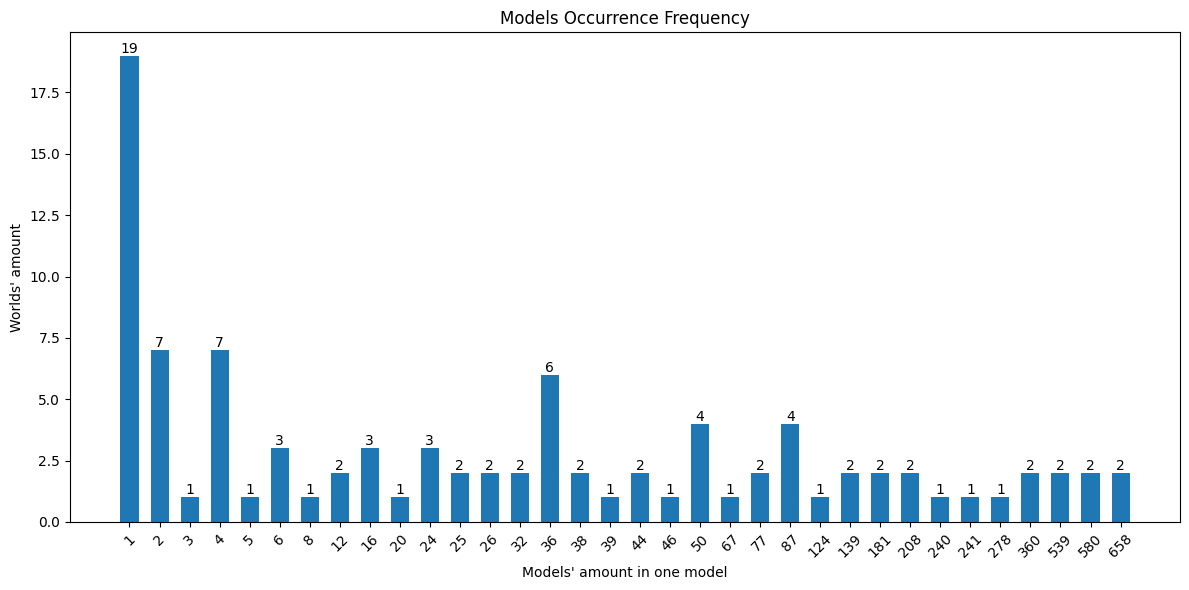

In [369]:
xs = [x[0] for x in models_amounts_counts] # without first element since it is the biggest
ys = [x[1] for x in models_amounts_counts]

positions = range(len(xs))

plt.figure(figsize=(12, 6))
bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs, rotation=45)
plt.xlabel("Models' amount in one model")
plt.ylabel("Worlds' amount")
plt.title("Models Occurrence Frequency")
plt.tight_layout()
plt.show()


### Includes Elements

In [370]:
includes_dict = {}
for world_file_path in unique_files:
    res = get_all_elements("include", world_file_path)
    for elem, depth in res:
        uri = elem.find("uri").text.strip()
        if not uri.startswith("model://") and not uri.startswith("https://fuel.gazebosim.org") and not uri.startswith("https://fuel.ignitionrobotics.org"):
            raise Exception("Unexpected URI inside <include> element was found.")
    includes_dict[world_file_path] = res

All URIs inside /<include/> elements are either links to local files or URLs of Gazebo Fuel website with models.

In [371]:
all_includes = [y for x in includes_dict.values() for y in x]

In [372]:
local_models = len(list(filter(lambda x: x[0].find("uri").text.strip().startswith("model://"), all_includes)))
fuel_models = len(all_includes) - local_models
print(f"All includes from all files: {len(all_includes)}")
print(f"Includes that have URI with the local model: {local_models}")
print(local_models / len(all_includes))
print(fuel_models / len(all_includes))

All includes from all files: 4615
Includes that have URI with the local model: 4560
0.9880823401950163
0.011917659804983749


98.8% of include elements are connected to a local model files or folders in a project. Only 1.2% are using Gazebo Fuel models in the worlds.

In [ ]:
includes_amounts = [len(v) for v in includes_dict.values()]
includes_amounts_counts = Counter(includes_amounts).items()

In [ ]:
includes_amounts_counts = sorted(includes_amounts_counts, key=lambda x: x[0])

In [375]:
includes_amounts_counts[0][1] / len(unique_files)

0.36585365853658536

36% of file have no includes

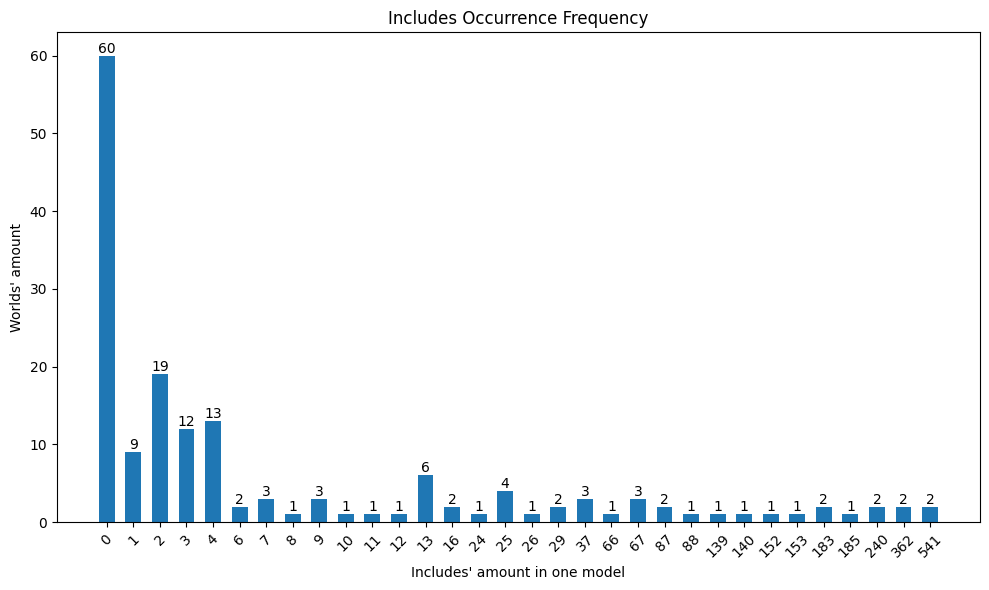

In [376]:
xs = [x[0] for x in includes_amounts_counts]
ys = [x[1] for x in includes_amounts_counts]

positions = range(len(xs))

plt.figure(figsize=(10, 6))
bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs, rotation=45)
plt.xlabel("Includes' amount in one model")
plt.ylabel("Worlds' amount")
plt.title("Includes Occurrence Frequency")
plt.tight_layout()
plt.show()


### Models and Includes Elements Together

In [377]:
models_and_includes_dict = {}
for world_file_path in unique_files:
    all_model_elements = get_all_elements("model", world_file_path)
    models_and_includes_dict[world_file_path] = all_model_elements
    all_include_elements = get_all_elements("include", world_file_path)
    models_and_includes_dict[world_file_path] += all_include_elements

# remove model files that have no nested models and includes
has_models_or_includes = {k: v for k, v in models_and_includes_dict.items() if v != []}
no_models_and_includes = {k: v for k, v in models_and_includes_dict.items() if v == []}

In [378]:
len(has_models_or_includes)

158

In [379]:
len(no_models_and_includes)

6

In [380]:
models_and_plugins_amounts = [len(v) for v in models_and_includes_dict.values()]
average_models_amount = sum(models_and_plugins_amounts) / len(models_and_plugins_amounts)
median_models_amount = statistics.median(models_and_plugins_amounts)

print(f"\nAverage models' and plugins' amount: {average_models_amount}")
print(f"Median models' and plugins' amount: {median_models_amount}")



Average models' and plugins' amount: 76.14024390243902
Median models' and plugins' amount: 9.0


In [381]:
models_and_includes_amounts = [len(v) for v in has_models_or_includes.values()]
models_and_includes_amounts_counts = Counter(models_and_includes_amounts).items()

In [382]:
models_and_includes_amounts_counts = sorted(models_and_includes_amounts_counts, key=lambda x: x[0])

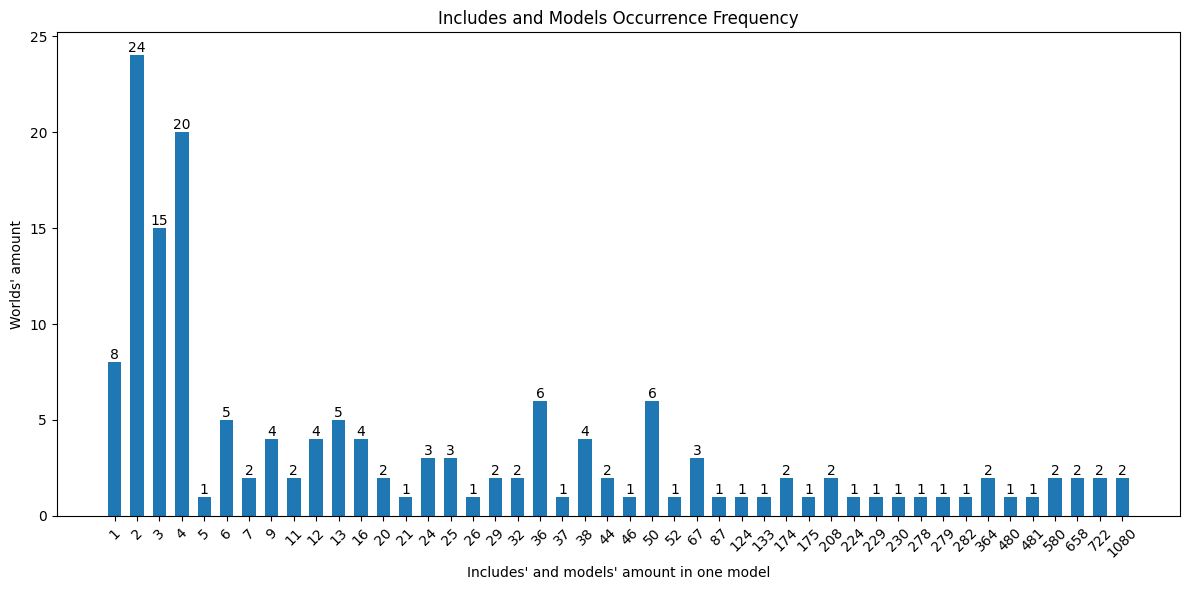

In [383]:
xs = [x[0] for x in models_and_includes_amounts_counts]
ys = [x[1] for x in models_and_includes_amounts_counts]

positions = range(len(xs))

plt.figure(figsize=(12, 6))
bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs, rotation=45)
plt.xlabel("Includes' and models' amount in one model")
plt.ylabel("Worlds' amount")
plt.title("Includes and Models Occurrence Frequency")
plt.tight_layout()
plt.show()


### Auxiliary Methods for Plugins, Joints, and Sensors
To have a more precise picture, models that are included in worlds using \<include\> element are also taken into account. This means that plugins, joints, and sensors that are inside those models will also be added up to the total amount of plugins, joints, and sensors in the world.

In [394]:
def find_sdf_file(folder_path):
    l = list(Path(folder_path).rglob('*.sdf'))
    return None if len(l) == 0 else l[0]

In [387]:
def get_subfolders(folder_path):
    return [f.name for f in folder_path.iterdir() if f.is_dir()]

In [405]:
def get_all_models_for_world(world_file_path):
    models = []
    if DATASET_WORLDS_STRING in world_file_path:
        relative_world_file_path = world_file_path.split(DATASET_WORLDS_STRING)[1]
        relative_models_folder_path = dataset_worlds_models_dict[relative_world_file_path]
        models_folder_path = Path(os.getcwd() + DATASET_WORLDS_STRING + relative_models_folder_path)
        models = get_subfolders(models_folder_path)
    else:
        split = world_file_path.split("/worlds/")[0]
        models_folder_path = Path(split + "/models")
        if models_folder_path.is_dir():
            models = get_subfolders(models_folder_path)
    return models, models_folder_path

In [406]:
def get_included_models(world_file_path):
    includes = get_all_elements("include", world_file_path)
    uris = [x[0].find("uri").text for x in includes]
    only_local = list(filter(lambda x: x.startswith("model://"), uris))
    model_names = [x.split("model://")[1] for x in only_local]
    return model_names

### Plugins Elements

In [ ]:
plugins_dict = {}
for world_file_path in unique_files:
    plugins_dict[world_file_path] = get_all_elements("plugin", world_file_path)

    models, models_folder_path = get_all_models_for_world(world_file_path)
    included_model_names = get_included_models(world_file_path)

    for model_name in included_model_names:
        if model_name in models:
            full_model_folder_path = str(models_folder_path) + "/" + model_name
            model_file_path = find_sdf_file(full_model_folder_path)
            if model_file_path:
                plugins = get_all_elements("plugin", model_file_path)
                plugins_dict[world_file_path] += plugins

In [408]:
plugins_amounts = [len(v) for v in plugins_dict.values()]
plugins_amounts_counts = Counter(plugins_amounts).items()
plugins_amounts_counts = sorted(plugins_amounts_counts, key=lambda x: x[0])

In [410]:
plugins_amounts_counts[0][1] / len(unique_files)

0.7439024390243902

74% of worlds have no plugins directly included in them

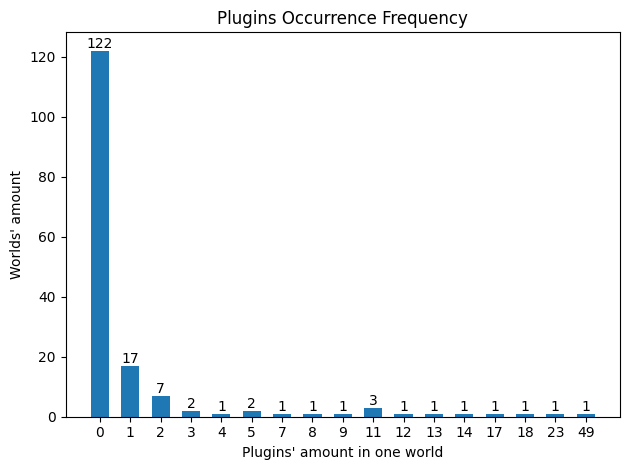

In [411]:
xs = [x[0] for x in plugins_amounts_counts]
ys = [x[1] for x in plugins_amounts_counts]

positions = range(len(xs))

bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs)
plt.xlabel("Plugins' amount in one world")
plt.ylabel("Worlds' amount")
plt.title("Plugins Occurrence Frequency")
plt.tight_layout()
plt.show()

In [412]:
all_plugins = [(y[0].attrib["name"], y[0].attrib["filename"]) for x in plugins_dict.values() for y in x]

In [ ]:
plugins_counts = Counter(all_plugins).items()

In [424]:
plugins_short_list = sorted(list(filter(lambda x: x[1] > 1, plugins_counts)), key=lambda x: x[1])

In [428]:
def find_duplicates(input_list):
    count = Counter(input_list)
    duplicates = [item for item, freq in count.items() if freq > 1]
    return duplicates

def process_tuples(input_list):
    duplicates = find_duplicates(map(lambda x: x[1], input_list))
    result = []
    
    for first, second in input_list:
        if second in duplicates:
            result.append(f"{first}, {second}")
        else:
            result.append(second)

    return result

In [434]:
find_duplicates([x[1] for x in [x[0] for x in plugins_short_list]])

['libgazebo_motor_model.so',
 'librotors_gazebo_motor_model.so',
 'libLiftDragPlugin.so']

In [435]:
find_duplicates([x[0] for x in [x[0] for x in plugins_short_list]])

['wind_plugin',
 'front_right_motor_model',
 'back_left_motor_model',
 'front_left_motor_model',
 'back_right_motor_model',
 'mavlink_interface']

In [425]:
len(plugins_counts)

88

In [426]:
len(plugins_short_list)

40

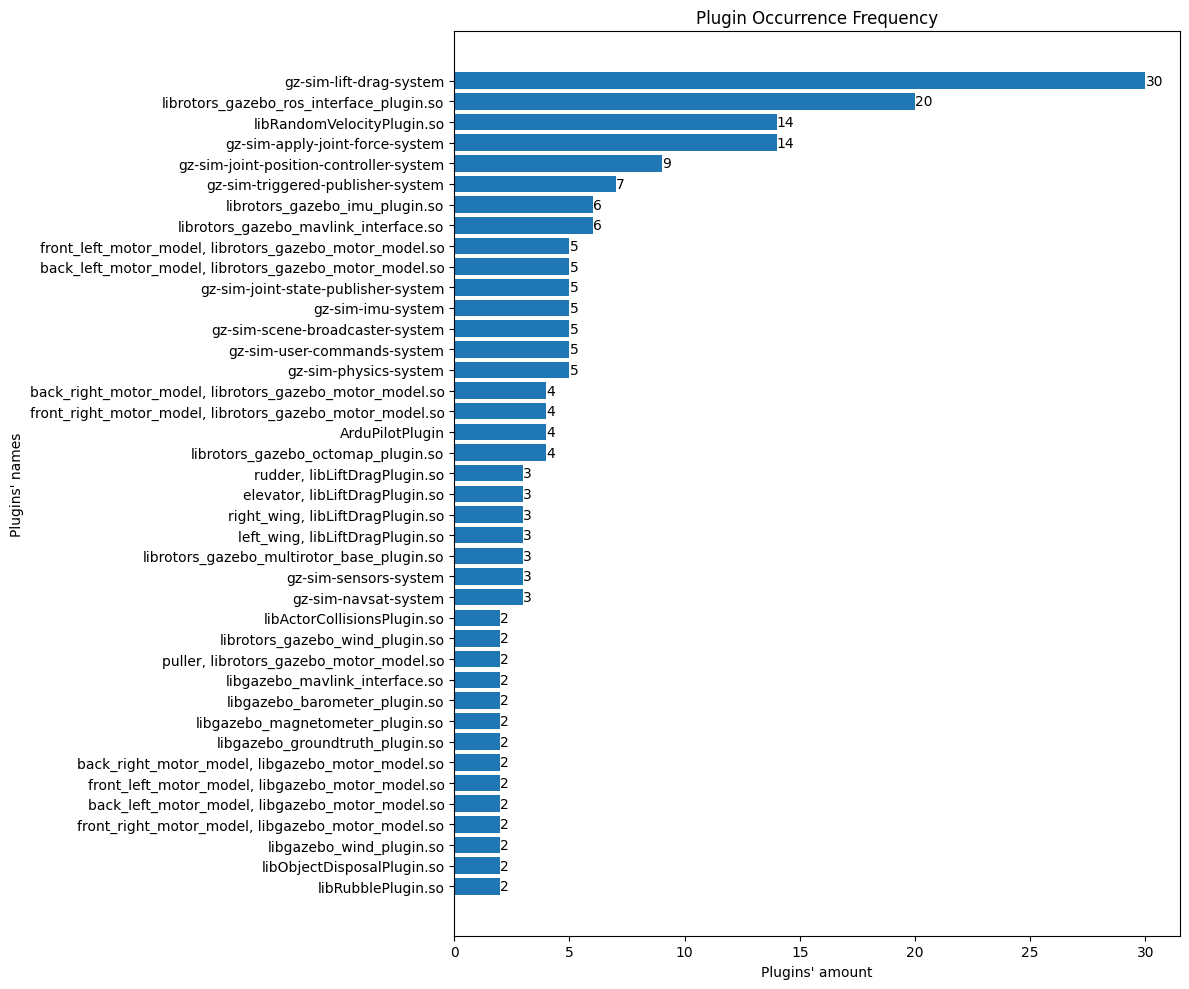

In [430]:
keys = process_tuples([x[0] for x in plugins_short_list])
values = [x[1] for x in plugins_short_list]

plt.figure(figsize=(12, 10))
bars = plt.barh(keys, values)
plt.bar_label(bars)
plt.xlabel("Plugins' amount")
plt.ylabel("Plugins' names")
plt.title("Plugin Occurrence Frequency")
plt.tight_layout()
plt.show()

### Joints Elements

In [289]:
joints_dict = {}
for world_file_path in unique_files:
    res = get_all_elements("joint", world_file_path)
    joints_dict[world_file_path] = res

In [436]:
joints_dict = {}
for world_file_path in unique_files:
    joints_dict[world_file_path] = get_all_elements("joint", world_file_path)

    models, models_folder_path = get_all_models_for_world(world_file_path)
    included_model_names = get_included_models(world_file_path)

    for model_name in included_model_names:
        if model_name in models:
            full_model_folder_path = str(models_folder_path) + "/" + model_name
            model_file_path = find_sdf_file(full_model_folder_path)
            if model_file_path:
                joints = get_all_elements("joint", model_file_path)
                joints_dict[world_file_path] += joints

In [438]:
joints_amounts = list(map(lambda x: len(x), joints_dict.values()))
joints_amounts_counts = Counter(joints_amounts)
joints_amounts_counts = sorted(joints_amounts_counts.items(), key=lambda x: x[0])

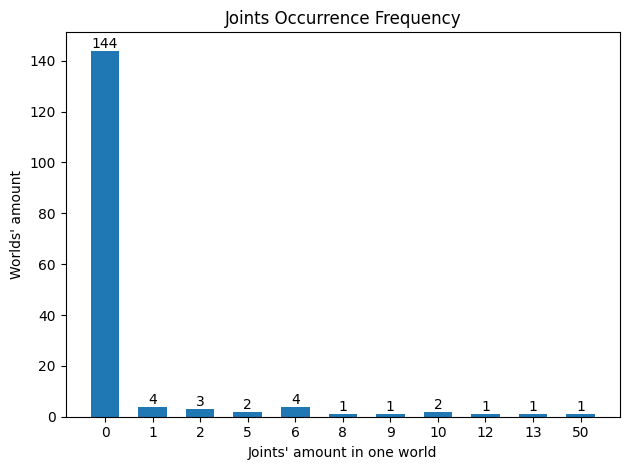

In [441]:
xs = [x[0] for x in joints_amounts_counts]
ys = [x[1] for x in joints_amounts_counts]

positions = range(len(xs))

bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs)
plt.xlabel("Joints' amount in one world")
plt.ylabel("Worlds' amount")
plt.title("Joints Occurrence Frequency")
plt.tight_layout()
plt.show()

### Sensors Elements

In [443]:
sensors_dict = {}
for model_file_path in unique_files:
    res = get_all_elements("sensor", model_file_path)
    sensors_dict[model_file_path] = res

In [445]:
sensors_dict = {}
for world_file_path in unique_files:
    sensors_dict[world_file_path] = get_all_elements("sensor", world_file_path)

    models, models_folder_path = get_all_models_for_world(world_file_path)
    included_model_names = get_included_models(world_file_path)

    for model_name in included_model_names:
        if model_name in models:
            full_model_folder_path = str(models_folder_path) + "/" + model_name
            model_file_path = find_sdf_file(full_model_folder_path)
            if model_file_path:
                sensors = get_all_elements("sensor", model_file_path)
                sensors_dict[world_file_path] += sensors

In [446]:
sensor_amounts = [len(x) for x in sensors_dict.values()]
sensor_amounts_counts = Counter(sensor_amounts)
sensor_amounts_counts = sorted(sensor_amounts_counts.items(), key=lambda x: x[0])

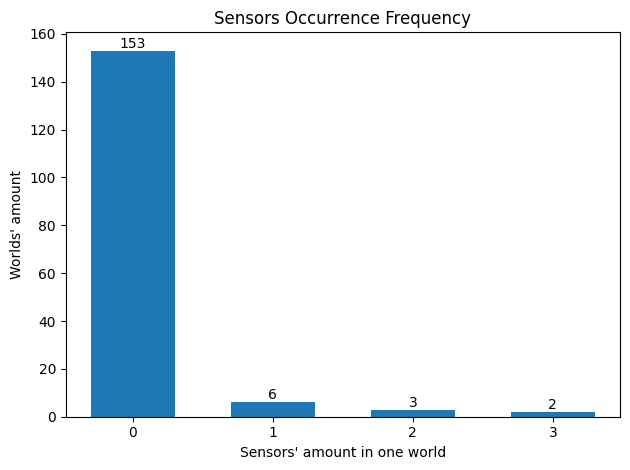

In [449]:
xs = [x[0] for x in sensor_amounts_counts]
ys = [x[1] for x in sensor_amounts_counts]

positions = range(len(xs))

bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs)
plt.xlabel("Sensors' amount in one world")
plt.ylabel("Worlds' amount")
plt.title("Sensors Occurrence Frequency")
plt.tight_layout()
plt.show()

### Actors Elements

In [450]:
actors_dict = {}
for model_file_path in unique_files:
    res = get_all_elements("actor", model_file_path)
    actors_dict[model_file_path] = res

In [451]:
actor_amounts = [len(x) for x in actors_dict.values()]
actor_amounts_counts = Counter(actor_amounts)
actor_amounts_counts = sorted(actor_amounts_counts.items(), key=lambda x: x[0])

In [452]:
actor_amounts_counts

[(0, 162), (2, 2)]

Only 2 worlds have inside them actors

### Links Elements

In [453]:
links_dict = {}
for world_file_path in unique_files:
    links_dict[world_file_path] = get_all_elements("link", world_file_path)

    models, models_folder_path = get_all_models_for_world(world_file_path)
    included_model_names = get_included_models(world_file_path)

    for model_name in included_model_names:
        if model_name in models:
            full_model_folder_path = str(models_folder_path) + "/" + model_name
            model_file_path = find_sdf_file(full_model_folder_path)
            if model_file_path:
                links = get_all_elements("link", model_file_path)
                links_dict[world_file_path] += links

In [454]:
link_amounts = [len(x) for x in links_dict.values()]
link_amounts_counts = Counter(link_amounts)
link_amounts_counts = sorted(link_amounts_counts.items(), key=lambda x: x[0])

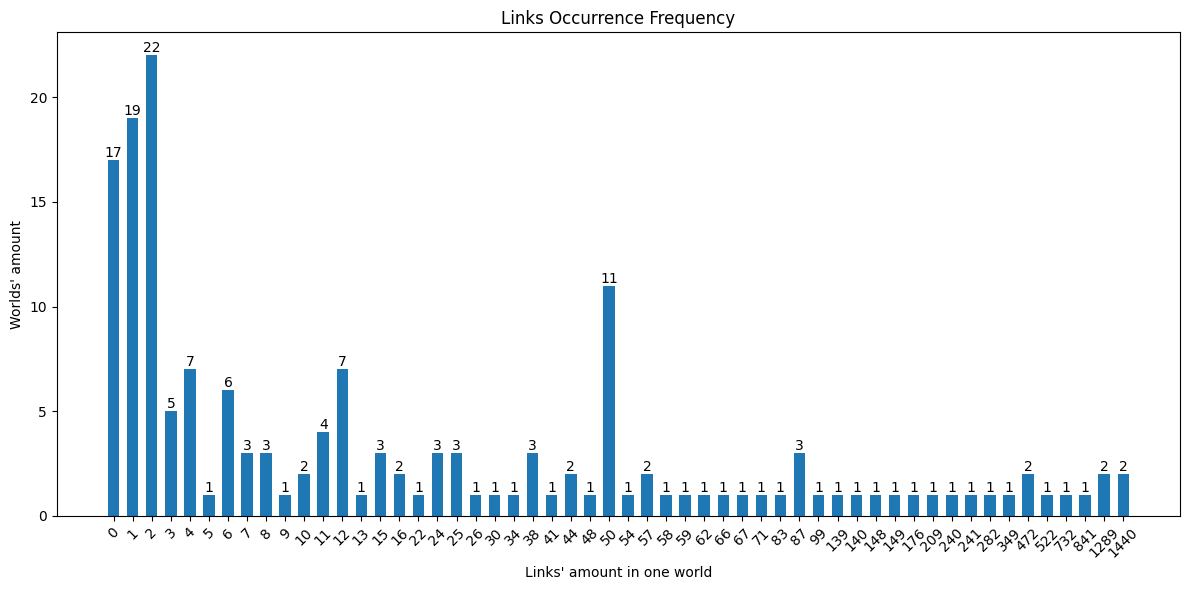

In [464]:
xs = [x[0] for x in link_amounts_counts]
ys = [x[1] for x in link_amounts_counts]

positions = range(len(xs))

plt.figure(figsize=(12, 6))
bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs, rotation=45)
plt.xlabel("Links' amount in one world")
plt.ylabel("Worlds' amount")
plt.title("Links Occurrence Frequency")
plt.tight_layout()
plt.show()

### Plugins + Joints + Sensors Elements Together

In [465]:
total_dict = {}
for world_file_path in unique_files:
    total_dict[world_file_path] = get_all_elements("plugin", world_file_path)
    total_dict[world_file_path] = get_all_elements("joint", world_file_path)
    total_dict[world_file_path] = get_all_elements("sensor", world_file_path)

    models, models_folder_path = get_all_models_for_world(world_file_path)
    included_model_names = get_included_models(world_file_path)

    for model_name in included_model_names:
        if model_name in models:
            full_model_folder_path = str(models_folder_path) + "/" + model_name
            model_file_path = find_sdf_file(full_model_folder_path)
            if model_file_path:
                total_dict[world_file_path] += get_all_elements("plugin", model_file_path)
                total_dict[world_file_path] += get_all_elements("joint", model_file_path)
                total_dict[world_file_path] += get_all_elements("sensor", model_file_path)

In [467]:
total_amounts = [len(x) for x in total_dict.values()]
total_amounts_counts = Counter(total_amounts)
total_amounts_counts = sorted(total_amounts_counts.items(), key=lambda x: x[0])

In [472]:
total_amounts_counts[0][1] / len(unique_files)

0.8719512195121951

87% of worlds have no plugins, joints, and sensors in them.

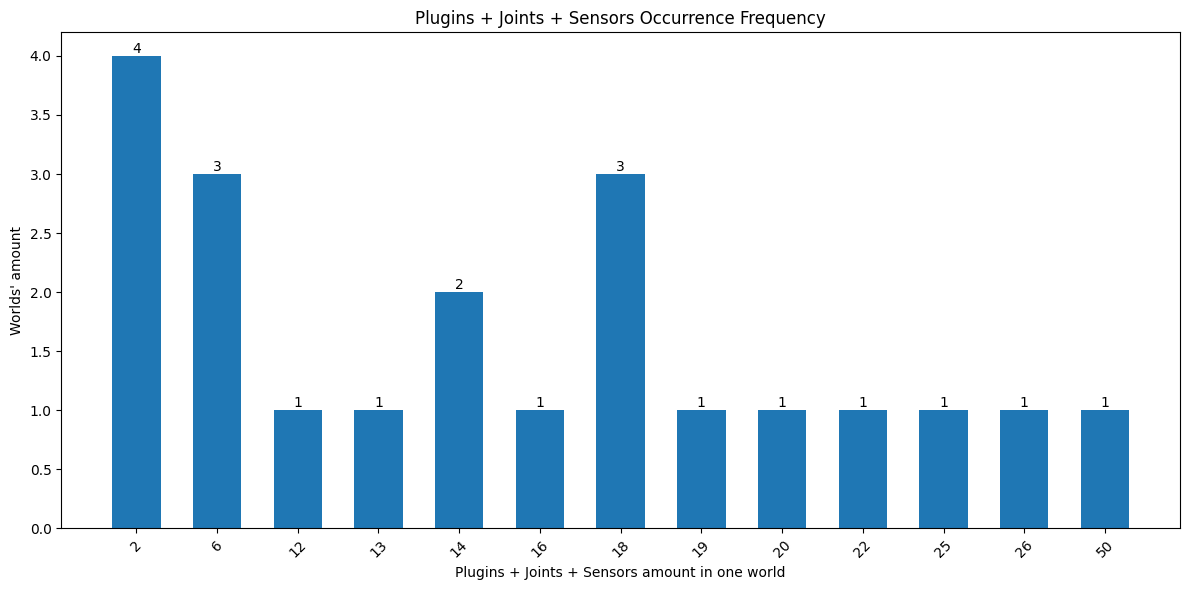

In [470]:
xs = [x[0] for x in total_amounts_counts[1:]]
ys = [x[1] for x in total_amounts_counts[1:]]

positions = range(len(xs))

plt.figure(figsize=(12, 6))
bars = plt.bar(positions, ys, width=0.6)
plt.bar_label(bars)
plt.xticks(positions, xs, rotation=45)
plt.xlabel("Plugins + Joints + Sensors amount in one world")
plt.ylabel("Worlds' amount")
plt.title("Plugins + Joints + Sensors Occurrence Frequency")
plt.tight_layout()
plt.show()